# Autores

Hellen Rakel Palma Enriquez

Maria Adelaida Suarez Restrepo


Se relacionan las rutas de acceso a los archivos y funciones necesarias, previamente compartidos con david.villanueva@udea.edu.co

df = https://drive.google.com/drive/u/0/folders/1VnvMHeTpsn7CujCmsV-qHCtYtIe-aa6n

funciones = https://drive.google.com/drive/u/0/folders/1gQvOmOBtBmVnlIptvsLqxzhKB8pAhyHQ

# Librerias y estaticos

In [219]:
# Manejo archivos
# ==============================================================================
import os
from os import listdir, path
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler


In [220]:
# Conexion con Drive
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [221]:
# Import de funciones
# ==============================================================================
import sys
sys.path.append('/content/drive/MyDrive/monografia/utils')
from funciones import multiple_plot

In [222]:
path_df = '/content/drive/MyDrive/monografia/dataset/dataset_base.csv'

ruta_eventos = '/content/drive/MyDrive/monografia/Tablas/eventos'
ruta_incidentes = '/content/drive/MyDrive/monografia/Tablas/Incidentes.xlsx'

# 1. Datos originales

Este dataset, creado a partir de datos de telemetria de una flota de carga, contiene información sobre eventos y accidentes en los viajes, y lo diseñamos con el objetivo analizar como predecir accidentes viales. Este conjunto de datos contiene tanto variables categóricas como numéricas, lo que permite explorar una variedad de factores que influyen en un accidente.

Por restricciones de privacidad no se otorga acceso a datos crudos.

https://drive.google.com/drive/folders/1E4CZE89iY9uu_N5pj9Gl2EKt7sYUBNz3?usp=sharing


##Tablas eventos

In [223]:
# Concatenamos tablas eventos
#(posible volcamiento, giro brusco,frenada brusca, aceleración brusca, posible accidente, exceso de velocidad prolongada)
# ==============================================================================
df_eventos = pd.DataFrame()
for i, df in enumerate([pd.read_csv(path.join(ruta_eventos, file), sep=';') for file in listdir(ruta_eventos)]):
    if i == 0:
        df_eventos = df
    else:
        df_eventos = pd.concat([df_eventos, df], axis=0)

df_eventos.reset_index(drop=True)
df_eventos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152042 entries, 0 to 59841
Data columns (total 38 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Address                  152028 non-null  object 
 1   Altitude                 152042 non-null  int64  
 2   CompanyId                152042 non-null  int64  
 3   CompanyName              152042 non-null  object 
 4   CustomerId               152042 non-null  int64  
 5   CustomerName             152042 non-null  object 
 6   DateTimeUTC              152042 non-null  object 
 7   DisplayName              152042 non-null  object 
 8   EngineStatus             152042 non-null  bool   
 9   EventDetail              535 non-null     object 
 10  EventLogId               152042 non-null  int64  
 11  EventTypeId              152042 non-null  int64  
 12  EventTypeName            152042 non-null  object 
 13  EventValue               76851 non-null   object 
 14  FleetId   

In [224]:
# Conservamos los eventos de los tractocamiones (flota en estudio)
# ==============================================================================
df_eventos = df_eventos[df_eventos['VehicleTypeName'] == "TRACTOCAMION"]
df_eventos = df_eventos[df_eventos['CompanyName'].str.contains("T1", na=False)]
df_eventos.shape

(149573, 38)

In [225]:
# Alias del conductor
# ==============================================================================
df_eventos = df_eventos.dropna(subset=['EventValue'])
df_eventos['CC'] = df_eventos['EventValue'].str.split(' - ').str[-1].str.strip()
df_eventos['Driver'] = df_eventos['EventValue'].apply(lambda x: (str(x.split(' - ')[-1]) + str(x.split(' - ')[0][-2:])))
df_eventos.shape

(76850, 40)

In [226]:
# Creamos variables y llaves necesarias
# ==============================================================================
df_eventos['DateTimeUTC'] = pd.to_datetime(df_eventos['DateTimeUTC'], errors='coerce')
df_eventos['fecha_h_ev'] = df_eventos['DateTimeUTC'].dt.date.astype(str)
df_eventos['llave'] = df_eventos['fecha_h_ev'] + df_eventos['DisplayName'].str.strip() + df_eventos['CC'].str.strip()
df_eventos.shape

(76850, 42)

In [227]:
# # Eliminamos registros duplicados según llave_event, para mantener el primer evento
# # ==============================================================================
'''
df_eventos['fecha_h_ev1'] = df_eventos['DateTimeUTC'].dt.date.astype(str)+ df_eventos['DateTimeUTC'].dt.floor('H').dt.time.astype(str)

df_eventos['llave1'] = df_eventos['fecha_h_ev1'] + df_eventos['DisplayName'].str.strip() + df_eventos['CC'].str.strip()
df_eventos['llave_event'] = df_eventos['llave1'] + df_eventos['EventTypeName']

df_eventos = df_eventos.sort_values(by=['llave_event', 'DateTimeUTC'])
df_eventos = df_eventos.drop_duplicates(subset='llave_event', keep='first')

df_eventos.shape
'''

"\ndf_eventos['fecha_h_ev1'] = df_eventos['DateTimeUTC'].dt.date.astype(str)+ df_eventos['DateTimeUTC'].dt.floor('H').dt.time.astype(str)\n\ndf_eventos['llave1'] = df_eventos['fecha_h_ev1'] + df_eventos['DisplayName'].str.strip() + df_eventos['CC'].str.strip()\ndf_eventos['llave_event'] = df_eventos['llave1'] + df_eventos['EventTypeName']\n\ndf_eventos = df_eventos.sort_values(by=['llave_event', 'DateTimeUTC'])\ndf_eventos = df_eventos.drop_duplicates(subset='llave_event', keep='first')\n\ndf_eventos.shape\n"

In [228]:
# Eliminamos variables basura
# ==============================================================================
cols_a_eliminar = df_eventos.columns[[
0,2,3,4,5,9,10,11,13,14,16,17,18,21,22,24,25,27,28,29,30,31,32,33,34,35,36,38,40
]]

# Eliminar variables especificadas
df_event = df_eventos.drop(columns=cols_a_eliminar)
df_event = df_event.dropna(subset=['DateTimeUTC'])
df_event.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76848 entries, 0 to 59841
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   Altitude          76848 non-null  int64              
 1   DateTimeUTC       76848 non-null  datetime64[ns, UTC]
 2   DisplayName       76848 non-null  object             
 3   EngineStatus      76848 non-null  bool               
 4   EventTypeName     76848 non-null  object             
 5   FleetName         76848 non-null  object             
 6   Latitude          76848 non-null  float64            
 7   Longitude         76848 non-null  float64            
 8   Speed             76848 non-null  int64              
 9   VehicleBrandName  76848 non-null  object             
 10  VehicleTypeName   76848 non-null  object             
 11  Driver            76848 non-null  object             
 12  llave             76848 non-null  object             
dtypes: boo

##Tabla Incidentes

In [229]:
# Importamos tabla incidentes
# ==============================================================================
df_incidentes = pd.read_excel(path.join(ruta_incidentes))
df_incidentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PartitionKey             623 non-null    int64         
 1   RowKey                   623 non-null    int64         
 2   Timestamp                623 non-null    datetime64[ns]
 3   AccidentTypeId           623 non-null    int64         
 4   AccidentTypeName         623 non-null    object        
 5   Address                  623 non-null    object        
 6   AffectedVictimTypeId     623 non-null    int64         
 7   AffectedVictimTypeName   623 non-null    object        
 8   AffectedWoundedTypeId    623 non-null    int64         
 9   AffectedWoundedTypeName  623 non-null    object        
 10  AreaId                   623 non-null    int64         
 11  AreaName                 623 non-null    object        
 12  ArrivalDepartmentId      623 non-nul

In [230]:
# Conservamos T1-PRIMARIA (flota en estudio)
# ==============================================================================
df_incidentes = df_incidentes[df_incidentes['CompanyName'].str.contains("T1", na=False)]
df_incidentes.shape

(622, 52)

In [231]:
# Creamos variables y llaves necesarias
# ==============================================================================
df_incidentes['fecha_inc'] = df_incidentes['SaveDate'].dt.date.astype(str)
df_incidentes['llave'] = df_incidentes['fecha_inc'].astype(str).str.strip() +df_incidentes['VehiclePlate'].str.strip() + df_incidentes['DriverDocument'].str.strip()
df_incidentes.shape

(622, 54)

In [232]:
# Eliminamos variables no necesarias de incidentes
# ==============================================================================
cols_a_eliminar = df_incidentes.columns[[
0,1,2,3,4,5,6,8,10,11,12,14,16,17,18,19,21,23,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52
]]
df_incidents = df_incidentes.drop(columns=cols_a_eliminar)
df_incidents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 622 entries, 0 to 622
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   AffectedVictimTypeName   622 non-null    object
 1   AffectedWoundedTypeName  622 non-null    object
 2   ArrivalDepartmentName    622 non-null    object
 3   ArrivalTownName          622 non-null    object
 4   DepartmentName           622 non-null    object
 5   DepartureDepartmentName  622 non-null    object
 6   DepartureTownName        622 non-null    object
 7   FatalitiesQuantity       622 non-null    int64 
 8   WoundedQuantity          622 non-null    int64 
 9   llave                    622 non-null    object
dtypes: int64(2), object(8)
memory usage: 53.5+ KB


# 2. Dataset

Eventos e incidentes

In [233]:
# Dataset de eventos relacionads con incidentes
# ==============================================================================
dataset = pd.merge(df_event, df_incidents, on='llave', how='left')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76902 entries, 0 to 76901
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   Altitude                 76902 non-null  int64              
 1   DateTimeUTC              76902 non-null  datetime64[ns, UTC]
 2   DisplayName              76902 non-null  object             
 3   EngineStatus             76902 non-null  bool               
 4   EventTypeName            76902 non-null  object             
 5   FleetName                76902 non-null  object             
 6   Latitude                 76902 non-null  float64            
 7   Longitude                76902 non-null  float64            
 8   Speed                    76902 non-null  int64              
 9   VehicleBrandName         76902 non-null  object             
 10  VehicleTypeName          76902 non-null  object             
 11  Driver                   769

In [234]:
# Creamos la variable de salida
# ==============================================================================
dataset['hasAccident'] = dataset['ArrivalTownName'].notna()

In [235]:
# Ajustamos los campos para los eventos que no resultaron en accidente
# ==============================================================================
for column in df_incidents.columns:
  if column not in ['FatalitiesQuantity', 'WoundedQuantity']:
    dataset[column] = dataset[column].fillna('NA')
  else:
    dataset[column] = dataset[column].fillna(0)

dataset = dataset.drop(columns=['llave'])
dataset.shape

(76902, 22)

In [236]:
# Guardamos dataset
dataset.to_csv(path_df, sep=';', index=False)

# 3. Análisis descriptivo

In [237]:
# importe de dataset
# ==============================================================================
df = pd.read_csv(path_df, sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76902 entries, 0 to 76901
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Altitude                 76902 non-null  int64  
 1   DateTimeUTC              76902 non-null  object 
 2   DisplayName              76902 non-null  object 
 3   EngineStatus             76902 non-null  bool   
 4   EventTypeName            76902 non-null  object 
 5   FleetName                76902 non-null  object 
 6   Latitude                 76902 non-null  float64
 7   Longitude                76902 non-null  float64
 8   Speed                    76902 non-null  int64  
 9   VehicleBrandName         76902 non-null  object 
 10  VehicleTypeName          76902 non-null  object 
 11  Driver                   76902 non-null  object 
 12  AffectedVictimTypeName   475 non-null    object 
 13  AffectedWoundedTypeName  475 non-null    object 
 14  ArrivalDepartmentName 

### Limpieza

In [238]:
#Verificación de registros duplicados
df.loc[df.duplicated()]

,Altitude,DateTimeUTC,DisplayName,EngineStatus,EventTypeName,FleetName,Latitude,Longitude,Speed,VehicleBrandName,...,AffectedVictimTypeName,AffectedWoundedTypeName,ArrivalDepartmentName,ArrivalTownName,DepartmentName,DepartureDepartmentName,DepartureTownName,FatalitiesQuantity,WoundedQuantity,hasAccident
10822,2071,2024-08-01 14:24:20+00:00,NLW058,True,Frenada brusca,T1-CENTRO,5.81641,-73.70128,55,DAF,...,Sin Especificar,Sin Especificar,BOGOTÁ D.C.,Bogota D.C.,BOGOTÁ D.C.,NORTE DE SANTANDER,Cúcuta,0.0,0.0,True
10834,2645,2024-08-01 14:59:30+00:00,NLW058,True,Frenada brusca,T1-CENTRO,5.62924,-73.81546,26,DAF,...,Sin Especificar,Sin Especificar,BOGOTÁ D.C.,Bogota D.C.,BOGOTÁ D.C.,NORTE DE SANTANDER,Cúcuta,0.0,0.0,True
16991,2581,2024-08-30 11:06:36+00:00,KOL749,True,Frenada brusca,T1-CENTRO,4.68047,-74.05863,0,FAW,...,Sin Especificar,Sin Especificar,BOGOTÁ D.C.,Bogota D.C.,BOGOTÁ D.C.,BOGOTÁ D.C.,Bogota D.C.,0.0,0.0,True
17008,2583,2024-08-30 12:09:05+00:00,KOL749,True,Frenada brusca,T1-CENTRO,4.60793,-74.11850,10,FAW,...,Sin Especificar,Sin Especificar,BOGOTÁ D.C.,Bogota D.C.,BOGOTÁ D.C.,BOGOTÁ D.C.,Bogota D.C.,0.0,0.0,True
21351,290,2024-09-20 13:51:53+00:00,JRY929,True,Frenada brusca,T1-CENTRO,5.20320,-74.68489,24,INTERNATIONAL,...,Sin Especificar,Sin Especificar,CALDAS,La Dorada,BOGOTÁ D.C.,BOGOTÁ D.C.,Bogota D.C.,0.0,0.0,True
21354,417,2024-09-20 13:54:47+00:00,JRY929,True,Frenada brusca,T1-CENTRO,5.19646,-74.67246,34,INTERNATIONAL,...,Sin Especificar,Sin Especificar,CALDAS,La Dorada,BOGOTÁ D.C.,BOGOTÁ D.C.,Bogota D.C.,0.0,0.0,True
21357,553,2024-09-20 13:57:40+00:00,JRY929,True,Frenada brusca,T1-CENTRO,5.18772,-74.66661,23,INTERNATIONAL,...,Sin Especificar,Sin Especificar,CALDAS,La Dorada,BOGOTÁ D.C.,BOGOTÁ D.C.,Bogota D.C.,0.0,0.0,True
21385,850,2024-09-20 15:45:07+00:00,JRY929,True,Frenada brusca,T1-CENTRO,5.06796,-74.43303,42,INTERNATIONAL,...,Sin Especificar,Sin Especificar,CALDAS,La Dorada,BOGOTÁ D.C.,BOGOTÁ D.C.,Bogota D.C.,0.0,0.0,True
21391,893,2024-09-20 15:51:34+00:00,JRY929,True,Frenada brusca,T1-CENTRO,5.05229,-74.38429,45,INTERNATIONAL,...,Sin Especificar,Sin Especificar,CALDAS,La Dorada,BOGOTÁ D.C.,BOGOTÁ D.C.,Bogota D.C.,0.0,0.0,True
21393,896,2024-09-20 15:52:02+00:00,JRY929,True,Frenada brusca,T1-CENTRO,5.04933,-74.38187,48,INTERNATIONAL,...,Sin Especificar,Sin Especificar,CALDAS,La Dorada,BOGOTÁ D.C.,BOGOTÁ D.C.,Bogota D.C.,0.0,0.0,True


In [239]:
df.describe()

,Altitude,Latitude,Longitude,Speed,FatalitiesQuantity,WoundedQuantity
count,76902.000000,76902.000000,76902.000000,76902.000000,76902.000000,76902.000000
mean,1387.192323,5.656128,-74.728927,38.697121,0.000065,0.000234
std,918.720144,1.926452,1.093987,21.689268,0.008063,0.015297
min,0.000000,0.856520,-77.582720,0.000000,0.000000,0.000000
25%,591.250000,4.529270,-75.576770,18.000000,0.000000,0.000000
50%,1275.000000,5.063165,-74.742085,42.000000,0.000000,0.000000
75%,2411.750000,6.698007,-74.067872,56.000000,0.000000,0.000000
max,3873.000000,11.545350,-72.264650,111.000000,1.000000,1.000000


## Visualización de datos

### Variables de entrada

In [240]:
#Listado de Variables Categoricas
catCols = df.select_dtypes(include = ["object", 'category', 'string']).columns.tolist()

#Listado Variables numericas
numCols=df.select_dtypes(include = ['float64','int32','int64']).columns.tolist()

/content/drive/MyDrive/monografia/utils/funciones.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,
/content/drive/MyDrive/monografia/utils/funciones.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  elif plot_type == 'boxplot':
/content/drive/MyDrive/monografia/utils/funciones.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,
/content/drive/MyDrive/monografia/utils/funciones.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  elif plot_type == 'boxplot':
/content/drive/MyDrive/monogra

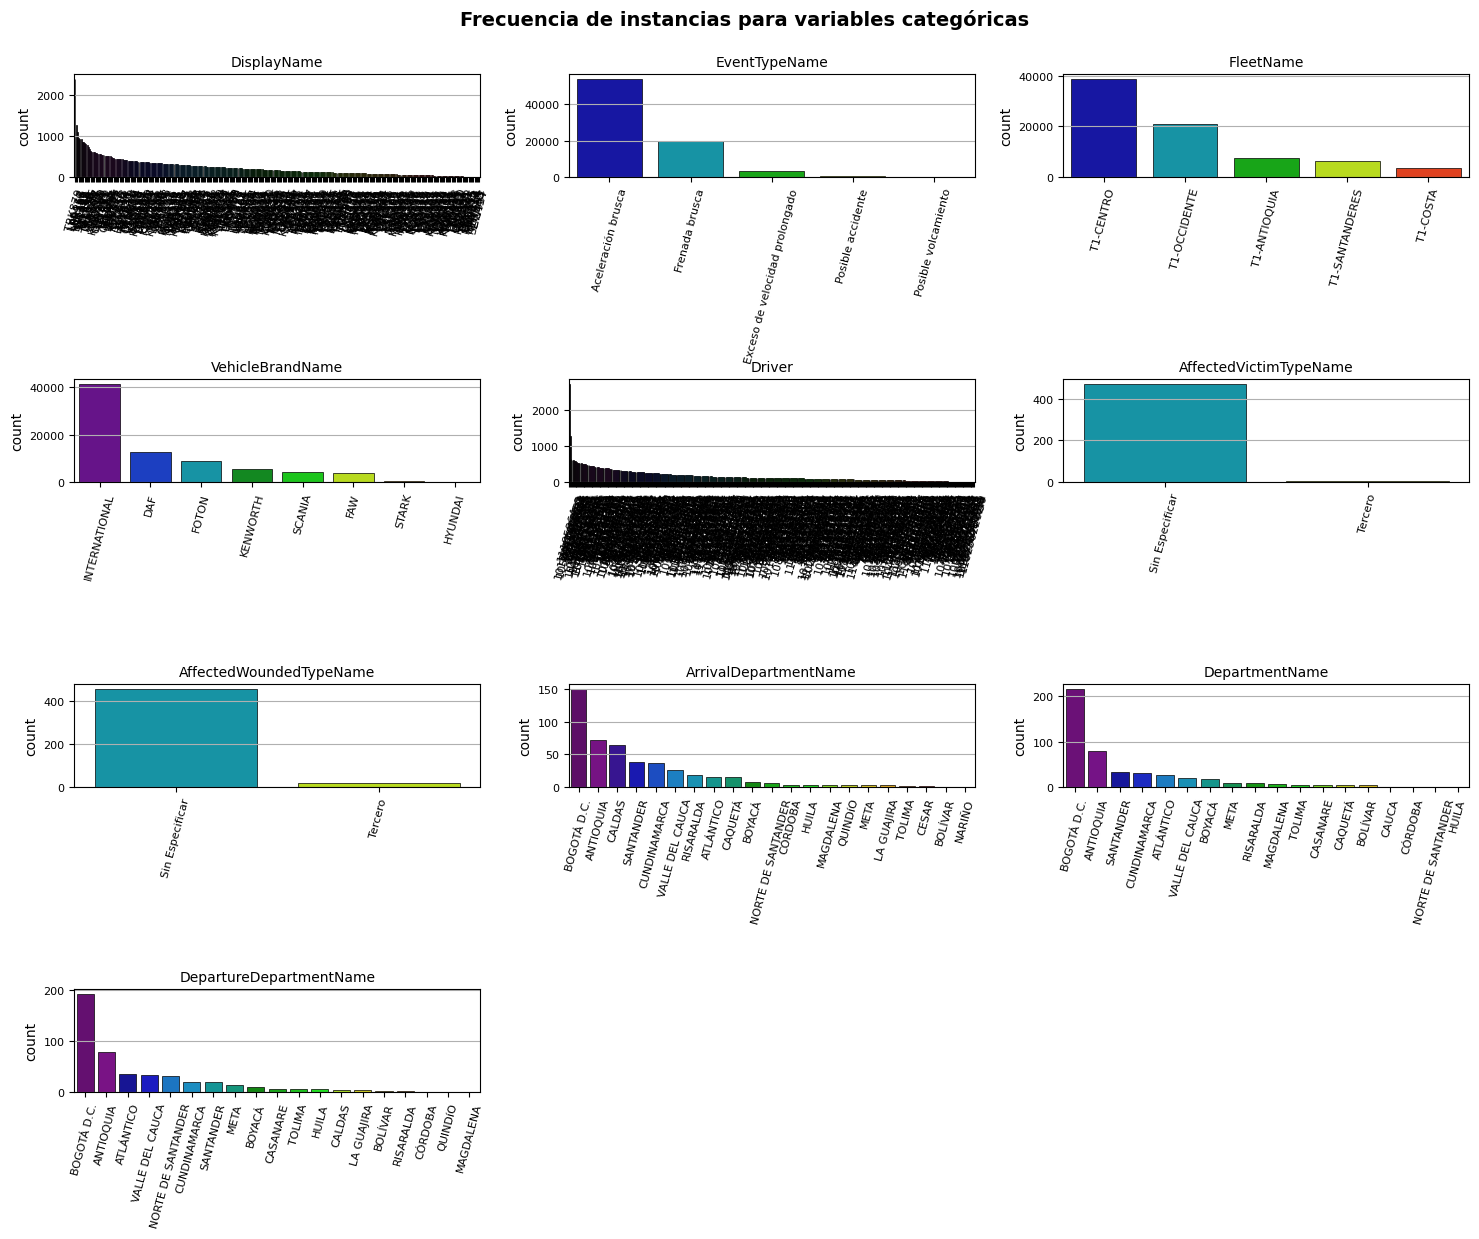

In [241]:
# Visualización de frecuencia de instancias para variables categóricas
# ==============================================================================
fiels_large = ['DepartureTownName', 'ArrivalTownName', 'DateTimeUTC', 'VehicleTypeName']
cols = [col for col in catCols if col not in fiels_large]
multiple_plot(3, df, cols, None, 'countplot', 'Frecuencia de instancias para variables categóricas', 75)

In [242]:
# Distribución de cada variable categórica en el conjunto de datos
# ==============================================================================
for col in catCols:
    print("="*5 + f" {col} " + "="*20)
    print(df[col].value_counts())
    print()

===== DateTimeUTC ====================
DateTimeUTC
2024-08-15 14:11:49+00:00    4
2024-07-31 14:14:49+00:00    3
2024-07-19 15:45:18+00:00    3
2024-09-07 13:59:02+00:00    3
2024-09-10 10:53:57+00:00    3
                            ..
2024-07-06 02:43:53+00:00    1
2024-07-06 02:38:33+00:00    1
2024-07-06 02:36:18+00:00    1
2024-07-06 02:35:25+00:00    1
2024-09-30 23:57:25+00:00    1
Name: count, Length: 76155, dtype: int64

===== DisplayName ====================
DisplayName
TRK879    2386
LXS436    1257
LPR163    1088
LPR156     964
LVY480     940
          ... 
JKV214       5
NLW053       5
TRJ641       5
SZW907       4
LTL494       3
Name: count, Length: 336, dtype: int64

===== EventTypeName ====================
EventTypeName
Aceleración brusca                53521
Frenada brusca                    19512
Exceso de velocidad prolongado     3418
Posible accidente                   437
Posible volcamiento                  14
Name: count, dtype: int64

===== FleetName ============

Necesitamos mas datos, inicialmente tomamos tres (julio-septiembre 2024) meses pero evidenciamos categorias ausentes.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable h

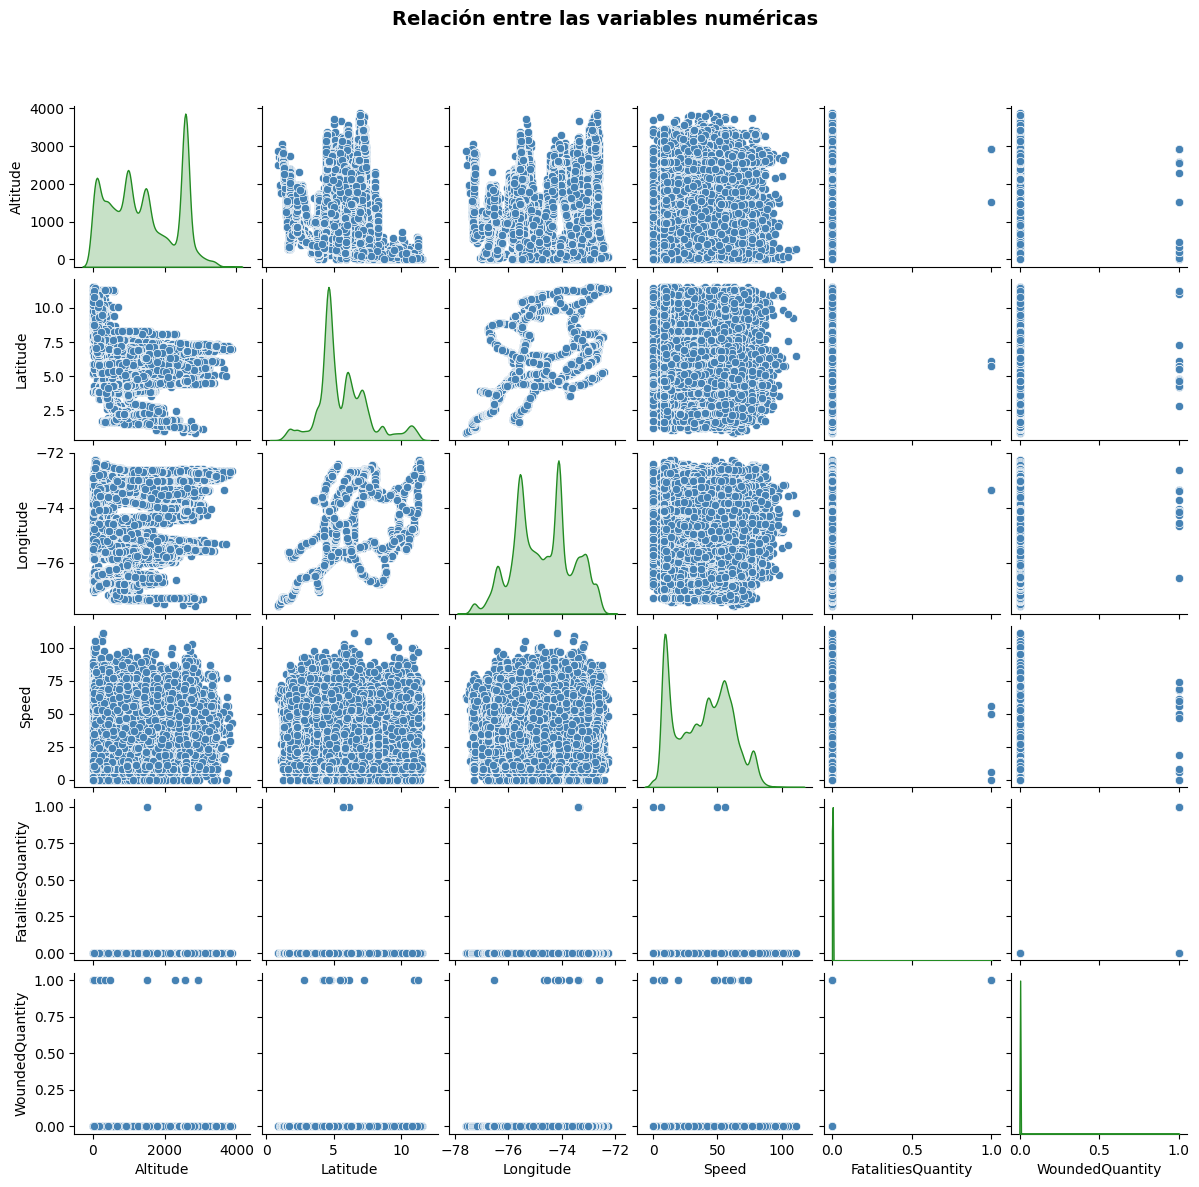

In [243]:
# Visualización de variables numéricas
# =================================================================
multiple_plot(1, df , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

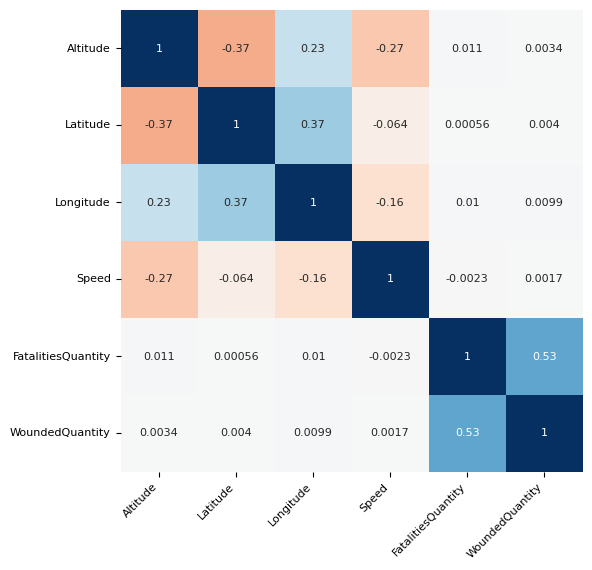

In [244]:
# Generación de la matriz de correlación y su mapa de calor
# =================================================================
matrizCorr = df[numCols].corr()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu',
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)


ax.tick_params(labelsize = 8)

## variables salida

In [245]:
# Distribución variable salida
# ==============================================================================
y = 'hasAccident'

df.groupby(y).hasAccident.count().sort_values(ascending=False)

,hasAccident
hasAccident,
False,76427
True,475


In [246]:
# validación de normalización variabe de salida
# ==============================================================================
df[y].value_counts(normalize=True)

,proportion
hasAccident,
False,0.993823
True,0.006177


In [247]:
# Visualización medidas de tendencia rspecto a nuestra variable de salida
# =================================================================
descriptive_stats = df.groupby(y).describe()
descriptive_stats_vertical = descriptive_stats.stack().reset_index()

print(descriptive_stats_vertical)

    hasAccident level_1      Altitude      Latitude     Longitude  \
0         False   count  76427.000000  76427.000000  76427.000000   
1         False    mean   1386.468905      5.656449    -74.730139   
2         False     std    918.587272      1.928491      1.095019   
3         False     min      0.000000      0.856520    -77.582720   
4         False     25%    591.000000      4.529110    -75.577080   
5         False     50%   1273.000000      5.063970    -74.748960   
6         False     75%   2408.000000      6.702845    -74.067240   
7         False     max   3873.000000     11.545350    -72.264650   
8          True   count    475.000000    475.000000    475.000000   
9          True    mean   1503.589474      5.604494    -74.533997   
10         True     std    933.556781      1.564963      0.892467   
11         True     min      3.000000      1.667970    -76.793060   
12         True     25%    708.500000      4.628530    -75.304725   
13         True     50%   1476.000

<ipython-input-247-f85606bb3891>:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  descriptive_stats_vertical = descriptive_stats.stack().reset_index()


/content/drive/MyDrive/monografia/utils/funciones.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,
/content/drive/MyDrive/monografia/utils/funciones.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cond.set_xticklabels(ax_cond.get_xticklabels(), rotation=rot)


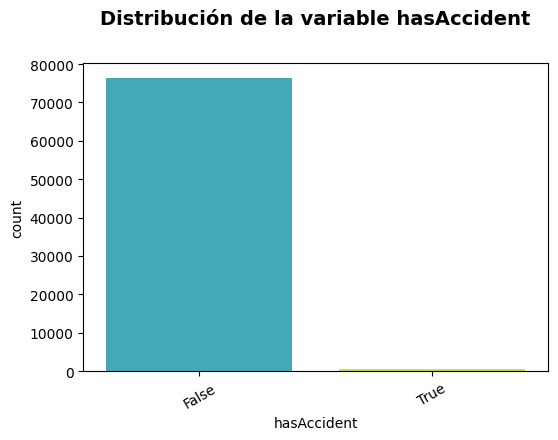

In [248]:
# Visualización distribucion de variable hasAccident
# ==============================================================================

multiple_plot(1, df , None, y, 'countplot', 'Distribución de la variable hasAccident',30)

Dado el desbalance significativo de la variable de salida hasAccidentNum, donde **False** (con accidente) es solo el 0.6% de los datos, planteamos para avanzar en el modelado evaluar si es necesario técnicas de balanceo para mejorar el rendimiento.
 Sobremuestreo de la clase minoritaria o SMOTE. Submuestreo de la clase mayoritaria inviable para el dataset.

## preparación de datos

### Imputaciones

In [258]:
# Identificación de valores nulos para las variables numéricas
# ==============================================================================
for col in df[numCols]:
    print (col, np.sum(pd.isnull(df[col])))

Altitude 0
Latitude 0
Longitude 0
Speed 0
FatalitiesQuantity 0
WoundedQuantity 0


In [250]:
# Identificación de valores nulos para las variables categóricas
# ==============================================================================
for col in df[catCols]:
    print (col, np.sum(pd.isnull(df[col])))

DateTimeUTC 0
DisplayName 0
EventTypeName 0
FleetName 0
VehicleBrandName 0
VehicleTypeName 0
Driver 0
AffectedVictimTypeName 76427
AffectedWoundedTypeName 76427
ArrivalDepartmentName 76427
ArrivalTownName 76427
DepartmentName 76427
DepartureDepartmentName 76427
DepartureTownName 76427


### Datos de prueba

In [251]:
# Porcentaje de filas para la primera parte (por ejemplo, 70%)
percentage_first_part = 0.90
n_rows_part1 = int(len(df) * percentage_first_part)
indices_part1 = df.sample(n=n_rows_part1, random_state=123).index
indices_part2 = df.index.difference(indices_part1)

# Dividir el DataFrame en dos partes
df = df.loc[indices_part1]
# dp = df.loc[indices_part2]

### Valores atipicos

In [252]:
# utilización de LocalOutlierFactor con 20 vecinos para identificar valores atípicos en las variables de entrada
# ==============================================================================

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = lof.fit_predict(df[numCols])
outliers = y_pred == -1

print('Indices de valores atípicos: ', df[outliers].index.tolist())
print(df.shape)

# Eliminar los valores atípicos del dataframe original se guardan en otro dataframe
df1 = df.loc[~outliers]

df1.shape


Indices de valores atípicos:  [46045, 10452, 37275, 71420, 29195, 63868, 44196, 71508, 69208, 11105, 45718, 68446, 61250, 32674, 34008, 64480, 76252, 52026, 15030, 67115, 66958, 36844, 48829, 57655, 2446, 41802, 24392, 49937, 10374, 70720, 22571, 9612, 31702, 46333, 59443, 2810, 48593, 57600, 52533, 42025, 32618, 23641, 60364, 42967, 61575, 7506, 7283, 39429, 43203, 2809, 59708, 47561, 40401, 22113, 34722, 72476, 3825, 40328, 71623, 25389, 72, 59051, 43313, 17603, 55639, 7848, 62587, 58223, 58853, 50948, 1993, 283, 74529, 9930, 48609, 20603, 52494, 33436, 66179, 21934, 22128, 1225, 66144, 69284, 1040, 69936, 33265, 70273, 28734, 58731, 618, 64833, 46348, 16049, 56102, 37711, 43350, 2077, 66273, 58663, 34307, 47478, 40819, 72402, 27330, 61440, 31407, 9747, 51397, 36615, 24949, 18233, 36587, 69640, 32397, 62807, 27901, 25092, 1912, 45100, 28542, 59791, 63785, 10182, 4413, 1021, 15702, 24289, 28832, 26198, 50681, 23295, 68849, 30235, 65057, 17467, 69115, 10368, 28132, 72864, 40253, 16484,

(62290, 22)

/content/drive/MyDrive/monografia/utils/funciones.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,
/content/drive/MyDrive/monografia/utils/funciones.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cond.set_xticklabels(ax_cond.get_xticklabels(), rotation=rot)


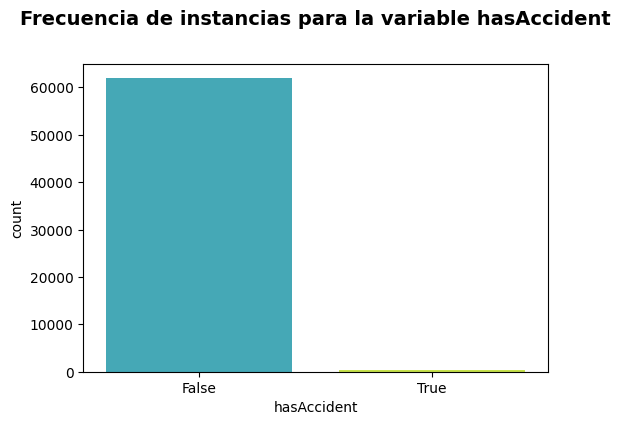

In [253]:
multiple_plot(1, df1, None, 'hasAccident', 'countplot', 'Frecuencia de instancias para la variable hasAccident',0)

### Sobremuestreo

In [254]:
# Se crea un objeto RandomOverSampler que permite crear copias aleatorias de las muestras de la clase
# minoritaria para igualar el número de muestras entre las diferentes clases.
# ==============================================================================

oversampler = RandomOverSampler()

X_resampled, y_resampled = oversampler.fit_resample(df.drop(y, axis=1), df[y])

df1 = pd.DataFrame(X_resampled, columns=df.columns.drop(y))
df2 = pd.DataFrame(y_resampled)

# Se concatenan los dataframes horizontalmente
df_balanced = pd.concat([df1, df2], axis=1)

df=df_balanced
df.shape

(137554, 22)

/content/drive/MyDrive/monografia/utils/funciones.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,
/content/drive/MyDrive/monografia/utils/funciones.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cond.set_xticklabels(ax_cond.get_xticklabels(), rotation=rot)


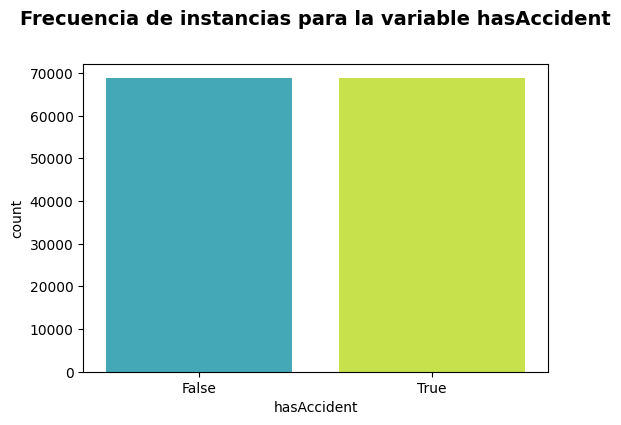

In [255]:
multiple_plot(1, df , None, y, 'countplot', 'Frecuencia de instancias para la variable hasAccident',0)